# Sliding Fit Strategy Visualization Notebook

This notebook is specifically designed for the SlidingFitStrategy, which uses a sliding window approach.
It re-trains the model every minute and shows how cointegration, model parameters, and trading signals evolve over time.
You can visualize the dynamic nature of the sliding window and how the relationship between instruments changes.

### 🎯 Key Features:

1. **Interactive Configuration**: 
   - Easy switching between CRYPTO and EQUITY configurations
   - Simple parameter adjustment for thresholds and training periods

2. **Single Pair Focus**: 
   - Instead of running multiple pairs, focuses on one pair at a time
   - Allows deep analysis of the relationship between two instruments

3. **Step-by-Step Visualization**:
   - **Raw price data**: Individual prices, normalized comparison, and price ratios
   - **Training analysis**: Cointegration testing and VECM model fitting
   - **Dis-equilibrium visualization**: Both raw and scaled dis-equilibrium with threshold lines
   - **Strategy execution**: Trading signal generation and visualization
   - **Prediction analysis**: Actual vs predicted prices with trading signals overlaid

4. **Rich Analytics**:
   - Cointegration status and VECM model details
   - Statistical summaries for all stages
   - Threshold crossing analysis
   - Trading signal breakdown

5. **Interactive Experimentation**:
   - Easy parameter modification
   - Re-run capabilities for different configurations
   - Support for both StaticFitStrategy and SlidingFitStrategy

### 🚀 How to Use:

1. **Start Jupyter**:
   ```bash
   cd src/notebooks
   jupyter notebook pairs_trading_visualization.ipynb
   ```

2. **Customize Your Analysis**:
   - Change `SYMBOL_A` and `SYMBOL_B` to your desired trading pair
   - Switch between `CRYPTO_CONFIG` and `EQT_CONFIG`
   - Choose your strategy (StaticFitStrategy or SlidingFitStrategy)
   - Adjust thresholds and parameters as needed

3. **Run and Visualize**:
   - Execute cells step by step to see the analysis unfold
   - Rich matplotlib visualizations show relationships and signals
   - Comprehensive summary at the end

The notebook provides exactly what you requested - a way to visualize the relationship between two instruments and their scaled dis-equilibrium, with all the stages of your pairs trading strategy clearly displayed and analyzed.


## Setup and Imports

In [1]:
# Trading Parameters Configuration
# Specify your configuration file, trading symbols and date here

# Configuration file selection
CONFIG_FILE = "equity"  # Options: "equity", "crypto", or custom filename (without .cfg extension)

# Trading pair symbols
SYMBOL_A = "COIN"   # Change this to your desired symbol A
SYMBOL_B = "MSTR"   # Change this to your desired symbol B

# Date for data file selection (format: YYYYMMDD)
TRADING_DATE = "20250605"  # Change this to your desired date



In [2]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
from IPython.display import clear_output

# Import our modules
from strategies import SlidingFitStrategy, PairState
from tools.data_loader import load_market_data
from tools.trading_pair import TradingPair
from results import BacktestResult

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("Setup complete!")

Setup complete!


## Configuration

In [3]:
# Load Configuration from Configuration Files using HJSON
import hjson
import os

def load_config_from_file(config_type="equity"):
    """Load configuration from configuration files using HJSON"""
    config_file = f"../../configuration/{config_type}.cfg"
    
    try:
        with open(config_file, 'r') as f:
            # HJSON handles comments, trailing commas, and other human-friendly features
            config = hjson.load(f)
        
        # Convert relative paths to absolute paths from notebook perspective
        if 'data_directory' in config:
            data_dir = config['data_directory']
            if data_dir.startswith('./'):
                # Convert relative path to absolute path from notebook's perspective
                config['data_directory'] = os.path.abspath(f"../../{data_dir[2:]}")
        
        return config
        
    except FileNotFoundError:
        print(f"Configuration file not found: {config_file}")
        return None
    except hjson.HjsonDecodeError as e:
        print(f"HJSON parsing error in {config_file}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error loading config from {config_file}: {e}")
        return None



In [4]:
print(f"Trading Parameters:")
print(f"  Configuration: {CONFIG_FILE}")
print(f"  Symbol A: {SYMBOL_A}")
print(f"  Symbol B: {SYMBOL_B}")
print(f"  Trading Date: {TRADING_DATE}")

# Load the specified configuration
print(f"\nLoading {CONFIG_FILE} configuration using HJSON...")
CONFIG = load_config_from_file(CONFIG_FILE)

if CONFIG:
    print(f"✓ Successfully loaded {CONFIG['security_type']} configuration")
    print(f"  Data directory: {CONFIG['data_directory']}")
    print(f"  Database table: {CONFIG['db_table_name']}")
    print(f"  Exchange: {CONFIG['exchange_id']}")
    print(f"  Training window: {CONFIG['training_minutes']} minutes")
    print(f"  Open threshold: {CONFIG['dis-equilibrium_open_trshld']}")
    print(f"  Close threshold: {CONFIG['dis-equilibrium_close_trshld']}")
    
    # Automatically construct data file name based on date and config type
    # if CONFIG['security_type'] == "CRYPTO":
    DATA_FILE = f"{TRADING_DATE}.mktdata.ohlcv.db"
    # elif CONFIG['security_type'] == "EQUITY":
    #     DATA_FILE = f"{TRADING_DATE}.alpaca_sim_md.db"
    # else:
    #     DATA_FILE = f"{TRADING_DATE}.mktdata.db"  # Default fallback

    # Update CONFIG with the specific data file and instruments
    CONFIG["datafiles"] = [DATA_FILE]
    CONFIG["instruments"] = [SYMBOL_A, SYMBOL_B]
    
    print(f"\nData Configuration:")
    print(f"  Data File: {DATA_FILE}")
    print(f"  Security Type: {CONFIG['security_type']}")
    
    # Verify data file exists
    import os
    data_file_path = f"{CONFIG['data_directory']}/{DATA_FILE}"
    if os.path.exists(data_file_path):
        print(f"  ✓ Data file found: {data_file_path}")
    else:
        print(f"  ⚠ Data file not found: {data_file_path}")
        print(f"    Please check if the date and file exist in the data directory")
        
        # List available files in the data directory
        try:
            data_dir = CONFIG['data_directory']
            if os.path.exists(data_dir):
                available_files = [f for f in os.listdir(data_dir) if f.endswith('.db')]
                print(f"    Available files in {data_dir}:")
                for file in sorted(available_files)[:5]:  # Show first 5 files
                    print(f"      - {file}")
                if len(available_files) > 5:
                    print(f"      ... and {len(available_files)-5} more files")
        except Exception as e:
            print(f"    Could not list files in data directory: {e}")
else:
    print("⚠ Failed to load configuration. Please check the configuration file.")
    print("Available configuration files:")
    config_dir = "../../configuration"
    if os.path.exists(config_dir):
        config_files = [f for f in os.listdir(config_dir) if f.endswith('.cfg')]
        for file in config_files:
            print(f"  - {file}")
    else:
        print(f"  Configuration directory not found: {config_dir}")


Trading Parameters:
  Configuration: equity
  Symbol A: COIN
  Symbol B: MSTR
  Trading Date: 20250605

Loading equity configuration using HJSON...
✓ Successfully loaded EQUITY configuration
  Data directory: /home/oleg/develop/pairs_trading/data/equity
  Database table: md_1min_bars
  Exchange: ALPACA
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 1

Data Configuration:
  Data File: 20250605.mktdata.ohlcv.db
  Security Type: EQUITY
  ✓ Data file found: /home/oleg/develop/pairs_trading/data/equity/20250605.mktdata.ohlcv.db


## Select Trading Pair and Initialize Strategy

In [5]:
# Initialize Strategy
# Trading pair and data file are now defined in the previous cell

# Initialize SlidingFitStrategy
STRATEGY = SlidingFitStrategy()

print(f"Strategy Initialization:")
print(f"  Selected pair: {SYMBOL_A} & {SYMBOL_B}")
print(f"  Data file: {DATA_FILE}")
print(f"  Strategy: {type(STRATEGY).__name__}")
print(f"\nStrategy characteristics:")
print(f"  - Sliding window training every minute")
print(f"  - Dynamic cointegration testing")
print(f"  - State-based position management")
print(f"  - Continuous model re-training")

Strategy Initialization:
  Selected pair: COIN & MSTR
  Data file: 20250605.mktdata.ohlcv.db
  Strategy: SlidingFitStrategy

Strategy characteristics:
  - Sliding window training every minute
  - Dynamic cointegration testing
  - State-based position management
  - Continuous model re-training


## Load and Prepare Market Data

In [6]:
# Load market data
datafile_path = f"{CONFIG['data_directory']}/{DATA_FILE}"
print(f"Loading data from: {datafile_path}")

market_data_df = load_market_data(datafile_path, config=CONFIG)

print(f"Loaded {len(market_data_df)} rows of market data")
print(f"Symbols in data: {market_data_df['symbol'].unique()}")
print(f"Time range: {market_data_df['tstamp'].min()} to {market_data_df['tstamp'].max()}")

# Create trading pair
pair = TradingPair(
    market_data=market_data_df,
    symbol_a=SYMBOL_A,
    symbol_b=SYMBOL_B,
    price_column=CONFIG["price_column"]
)

print(f"\nCreated trading pair: {pair}")
print(f"Market data shape: {pair.market_data_.shape}")
print(f"Column names: {pair.colnames()}")

# Calculate maximum possible iterations for sliding window
training_minutes = CONFIG["training_minutes"]
max_iterations = len(pair.market_data_) - training_minutes
print(f"\nSliding window analysis:")
print(f"  Training window size: {training_minutes} minutes")
print(f"  Maximum iterations: {max_iterations}")
print(f"  Total analysis time: ~{max_iterations} minutes")

# Display sample data
print(f"\nSample data:")
display(pair.market_data_.head())

Loading data from: /home/oleg/develop/pairs_trading/data/equity/20250605.mktdata.ohlcv.db
Loaded 782 rows of market data
Symbols in data: ['COIN' 'MSTR']
Time range: 2025-06-05 13:30:00 to 2025-06-05 20:00:00

Created trading pair: COIN & MSTR
Market data shape: (391, 3)
Column names: ['close_COIN', 'close_MSTR']

Sliding window analysis:
  Training window size: 120 minutes
  Maximum iterations: 271
  Total analysis time: ~271 minutes

Sample data:


tstamp  close_COIN  close_MSTR
0 2025-06-05 13:30:00     263.380    384.7700
1 2025-06-05 13:31:00     265.385    382.7806
2 2025-06-05 13:32:00     263.735    379.8300
3 2025-06-05 13:33:00     264.250    380.0400
4 2025-06-05 13:34:00     262.230    379.6400

## Run SlidingFitStrategy with Real-Time Visualization

In [7]:
# Run the sliding strategy with detailed tracking
print(f"Running SlidingFitStrategy on {pair}...")
print(f"This will process {max_iterations} minutes of data with sliding training windows.\n")

# Initialize tracking variables
iteration_data = []
cointegration_history = []
beta_history = []
alpha_history = []
state_history = []
disequilibrium_history = []
scaled_disequilibrium_history = []
timestamp_history = []
training_mu_history = []
training_std_history = []

# Initialize the strategy state
pair.user_data_['state'] = PairState.INITIAL
pair.user_data_["trades"] = pd.DataFrame(columns=STRATEGY.TRADES_COLUMNS)
pair.user_data_["is_cointegrated"] = False

bt_result = BacktestResult(config=CONFIG)
training_minutes = CONFIG["training_minutes"]
open_threshold = CONFIG["dis-equilibrium_open_trshld"]
close_threshold = CONFIG["dis-equilibrium_close_trshld"]

# Limit iterations for demonstration (change this to max_iterations for full run)
max_demo_iterations = min(200, max_iterations)  # Process first 200 minutes
print(f"Processing first {max_demo_iterations} iterations for demonstration...\n")

for curr_training_start_idx in range(max_demo_iterations):
    if curr_training_start_idx % 20 == 0:
        print(f"Processing iteration {curr_training_start_idx}/{max_demo_iterations}...")

    # Get datasets for this iteration
    pair.get_datasets(
        training_minutes=training_minutes,
        training_start_index=curr_training_start_idx,
        testing_size=1
    )

    if len(pair.training_df_) < training_minutes:
        print(f"Iteration {curr_training_start_idx}: Not enough training data. Stopping.")
        break

    # Record timestamp for this iteration
    current_timestamp = pair.testing_df_['tstamp'].iloc[0] if len(pair.testing_df_) > 0 else None
    timestamp_history.append(current_timestamp)

    # Train and test cointegration
    try:
        is_cointegrated = pair.train_pair()
        cointegration_history.append(is_cointegrated)

        if is_cointegrated:
            # Record model parameters
            beta_history.append(pair.vecm_fit_.beta.flatten())
            alpha_history.append(pair.vecm_fit_.alpha.flatten())
            training_mu_history.append(pair.training_mu_)
            training_std_history.append(pair.training_std_)

            # Generate prediction for current minute
            pair.predict()

            if len(pair.predicted_df_) > 0:
                current_disequilibrium = pair.predicted_df_['disequilibrium'].iloc[0]
                current_scaled_disequilibrium = pair.predicted_df_['scaled_disequilibrium'].iloc[0]
                disequilibrium_history.append(current_disequilibrium)
                scaled_disequilibrium_history.append(current_scaled_disequilibrium)
            else:
                disequilibrium_history.append(np.nan)
                scaled_disequilibrium_history.append(np.nan)
        else:
            # No cointegration
            beta_history.append(None)
            alpha_history.append(None)
            training_mu_history.append(np.nan)
            training_std_history.append(np.nan)
            disequilibrium_history.append(np.nan)
            scaled_disequilibrium_history.append(np.nan)

    except Exception as e:
        print(f"Iteration {curr_training_start_idx}: Training failed: {str(e)}")
        cointegration_history.append(False)
        beta_history.append(None)
        alpha_history.append(None)
        training_mu_history.append(np.nan)
        training_std_history.append(np.nan)
        disequilibrium_history.append(np.nan)
        scaled_disequilibrium_history.append(np.nan)

    # Record current state
    current_state = pair.user_data_.get('state', PairState.INITIAL)
    state_history.append(current_state)

print(f"\nCompleted {len(cointegration_history)} iterations")
print(f"Cointegration rate: {sum(cointegration_history)/len(cointegration_history)*100:.1f}%")

Running SlidingFitStrategy on COIN & MSTR...
This will process 271 minutes of data with sliding training windows.

Processing first 200 iterations for demonstration...

Processing iteration 0/200...
COIN & MSTR: is_cointegrated=False pvalue=0.29476776822663775
COIN & MSTR: is_cointegrated=True pvalue=0.03322921089121464
COIN & MSTR: is_cointegrated=True pvalue=0.0009997257779409195
COIN & MSTR: is_cointegrated=True pvalue=2.767269944502344e-05
COIN & MSTR: is_cointegrated=True pvalue=0.0052836812788287
COIN & MSTR: is_cointegrated=True pvalue=0.00034072335153102263
COIN & MSTR: is_cointegrated=False pvalue=0.17079098520985098
COIN & MSTR: is_cointegrated=False pvalue=0.09681158936526507
COIN & MSTR: is_cointegrated=False pvalue=0.0889054767390306
COIN & MSTR: is_cointegrated=False pvalue=0.16465622124479123
COIN & MSTR: is_cointegrated=False pvalue=0.3103052245978475
COIN & MSTR: is_cointegrated=False pvalue=0.37233013436490103
COIN & MSTR: is_cointegrated=False pvalue=0.44982915505719

## Visualize Sliding Window Results

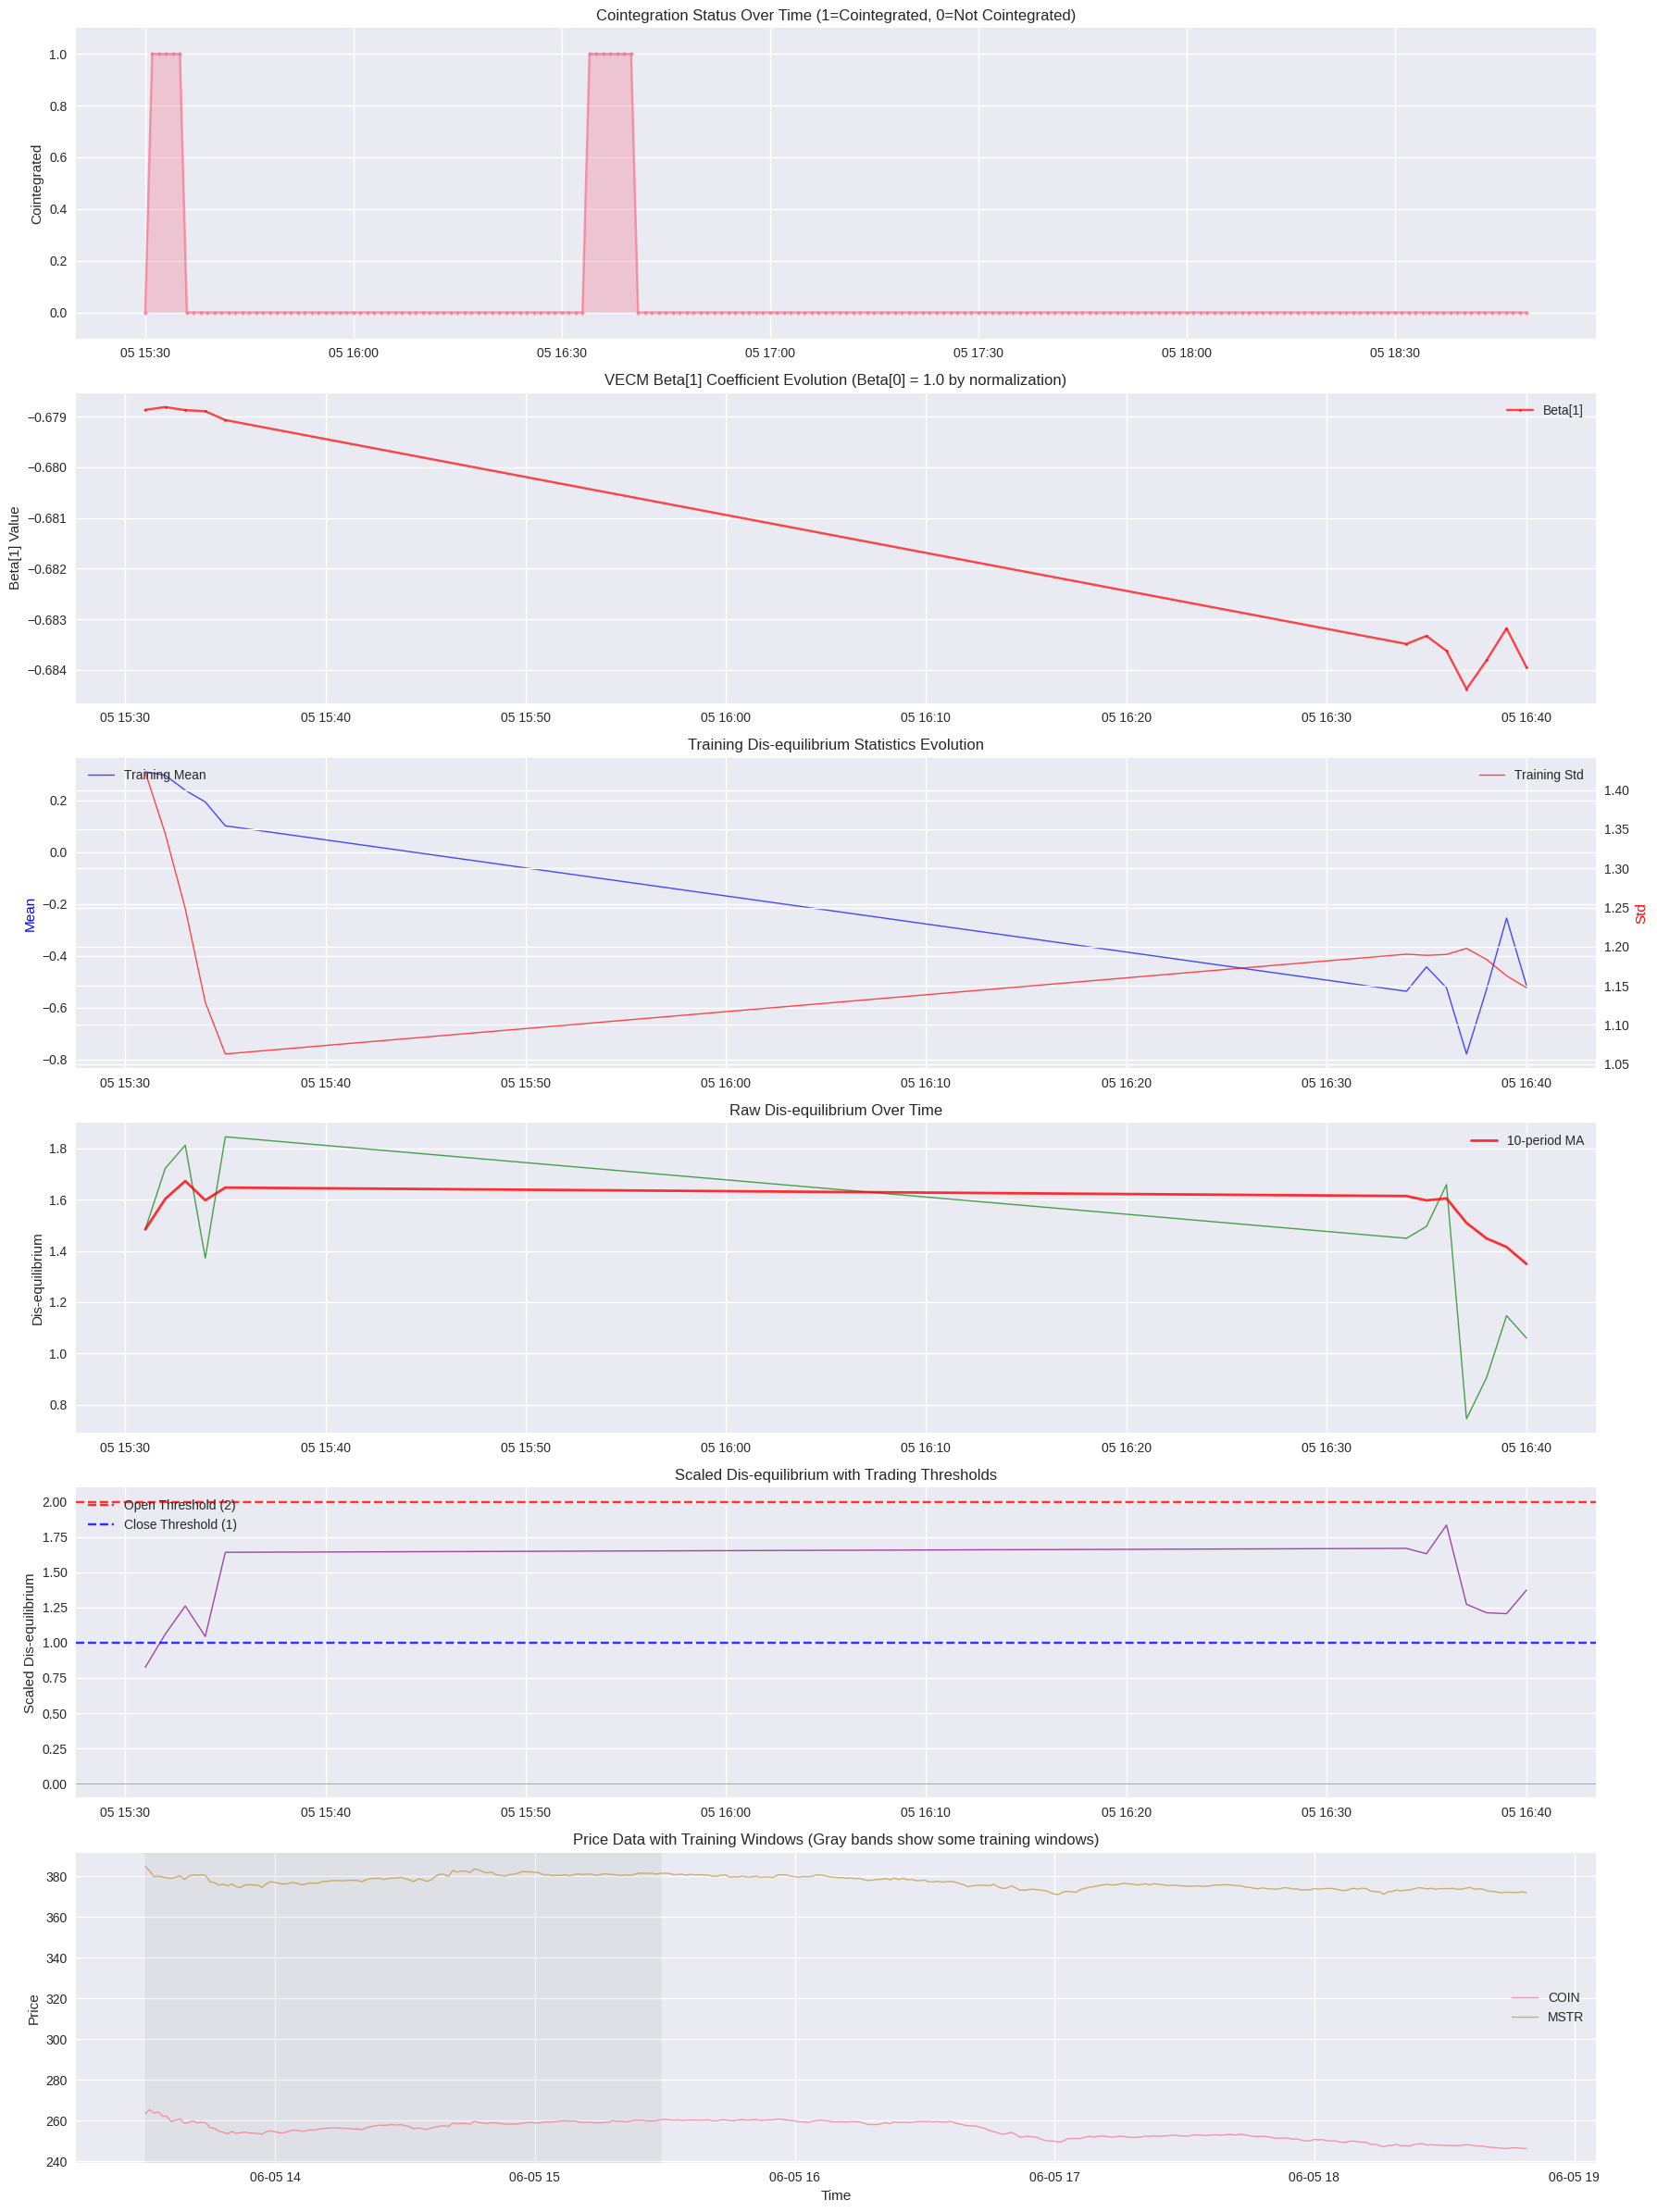


SLIDING WINDOW ANALYSIS SUMMARY
Total iterations processed: 200
Cointegration episodes: 12
Cointegration rate: 6.0%
Beta coefficient stability: Std = [4.53246652e-17 2.37413616e-03]
Open threshold breaches: 0 (0.0%)


In [8]:
# Create comprehensive visualization of sliding window results
fig, axes = plt.subplots(6, 1, figsize=(18, 24))

# Filter valid timestamps
valid_timestamps = [ts for ts in timestamp_history if ts is not None]
n_points = len(valid_timestamps)

if n_points == 0:
    print("No valid data points to visualize")
else:
    # 1. Cointegration Status Over Time
    cointegration_values = [1 if coint else 0 for coint in cointegration_history[:n_points]]
    axes[0].plot(valid_timestamps, cointegration_values, 'o-', alpha=0.7, markersize=3)
    axes[0].fill_between(valid_timestamps, cointegration_values, alpha=0.3)
    axes[0].set_title('Cointegration Status Over Time (1=Cointegrated, 0=Not Cointegrated)')
    axes[0].set_ylabel('Cointegrated')
    axes[0].set_ylim(-0.1, 1.1)
    axes[0].grid(True)

    # 2. Beta Coefficients Evolution
    valid_betas = []
    beta_timestamps = []
    for i, beta in enumerate(beta_history[:n_points]):
        if beta is not None and i < len(valid_timestamps):
            valid_betas.append(beta)
            beta_timestamps.append(valid_timestamps[i])

    if valid_betas:
        beta_array = np.array(valid_betas)
        axes[1].plot(beta_timestamps, beta_array[:, 1], 'o-', alpha=0.7, markersize=2,
                    label='Beta[1]', color='red')
        axes[1].set_title('VECM Beta[1] Coefficient Evolution (Beta[0] = 1.0 by normalization)')
        axes[1].set_ylabel('Beta[1] Value')
        axes[1].legend()
        axes[1].grid(True)

    # 3. Training Mean and Std Evolution
    valid_mu = [mu for mu in training_mu_history[:n_points] if not np.isnan(mu)]
    valid_std = [std for std in training_std_history[:n_points] if not np.isnan(std)]
    mu_timestamps = [valid_timestamps[i] for i, mu in enumerate(training_mu_history[:n_points]) if not np.isnan(mu)]

    if valid_mu:
        axes[2].plot(mu_timestamps, valid_mu, 'b-', alpha=0.7, label='Training Mean', linewidth=1)
        ax2_twin = axes[2].twinx()
        ax2_twin.plot(mu_timestamps, valid_std, 'r-', alpha=0.7, label='Training Std', linewidth=1)
        axes[2].set_title('Training Dis-equilibrium Statistics Evolution')
        axes[2].set_ylabel('Mean', color='b')
        ax2_twin.set_ylabel('Std', color='r')
        axes[2].grid(True)
        axes[2].legend(loc='upper left')
        ax2_twin.legend(loc='upper right')

    # 4. Raw Dis-equilibrium Over Time
    valid_diseq = [diseq for diseq in disequilibrium_history[:n_points] if not np.isnan(diseq)]
    diseq_timestamps = [valid_timestamps[i] for i, diseq in enumerate(disequilibrium_history[:n_points]) if not np.isnan(diseq)]

    if valid_diseq:
        axes[3].plot(diseq_timestamps, valid_diseq, 'g-', alpha=0.7, linewidth=1)
        # Add rolling mean
        if len(valid_diseq) > 10:
            rolling_mean = pd.Series(valid_diseq).rolling(window=10, min_periods=1).mean()
            axes[3].plot(diseq_timestamps, rolling_mean, 'r-', alpha=0.8, linewidth=2, label='10-period MA')
            axes[3].legend()
        axes[3].set_title('Raw Dis-equilibrium Over Time')
        axes[3].set_ylabel('Dis-equilibrium')
        axes[3].grid(True)

    # 5. Scaled Dis-equilibrium with Thresholds
    valid_scaled_diseq = [diseq for diseq in scaled_disequilibrium_history[:n_points] if not np.isnan(diseq)]
    scaled_diseq_timestamps = [valid_timestamps[i] for i, diseq in enumerate(scaled_disequilibrium_history[:n_points]) if not np.isnan(diseq)]

    if valid_scaled_diseq:
        axes[4].plot(scaled_diseq_timestamps, valid_scaled_diseq, 'purple', alpha=0.7, linewidth=1)
        axes[4].axhline(y=open_threshold, color='red', linestyle='--', alpha=0.8,
                       label=f'Open Threshold ({open_threshold})')
        axes[4].axhline(y=close_threshold, color='blue', linestyle='--', alpha=0.8,
                       label=f'Close Threshold ({close_threshold})')
        axes[4].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
        axes[4].set_title('Scaled Dis-equilibrium with Trading Thresholds')
        axes[4].set_ylabel('Scaled Dis-equilibrium')
        axes[4].legend()
        axes[4].grid(True)

    # 6. Price Data with Training Windows
    # Show original price data with indication of training windows
    colname_a, colname_b = pair.colnames()
    price_data = pair.market_data_[:n_points + training_minutes].copy()

    axes[5].plot(price_data['tstamp'], price_data[colname_a], alpha=0.7, label=f'{SYMBOL_A}', linewidth=1)
    axes[5].plot(price_data['tstamp'], price_data[colname_b], alpha=0.7, label=f'{SYMBOL_B}', linewidth=1)

    # Highlight training windows
    for i in range(0, min(n_points, 10), max(1, n_points//20)):  # Show every 20th window
        start_idx = i
        end_idx = i + training_minutes
        if end_idx < len(price_data):
            window_data = price_data.iloc[start_idx:end_idx]
            axes[5].axvspan(window_data['tstamp'].iloc[0], window_data['tstamp'].iloc[-1],
                           alpha=0.1, color='gray')

    axes[5].set_title(f'Price Data with Training Windows (Gray bands show some training windows)')
    axes[5].set_ylabel('Price')
    axes[5].set_xlabel('Time')
    axes[5].legend()
    axes[5].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n" + "="*80)
print(f"SLIDING WINDOW ANALYSIS SUMMARY")
print(f"="*80)
print(f"Total iterations processed: {n_points}")
print(f"Cointegration episodes: {sum(cointegration_history[:n_points])}")
print(f"Cointegration rate: {sum(cointegration_history[:n_points])/n_points*100:.1f}%")
if valid_betas:
    print(f"Beta coefficient stability: Std = {np.std(beta_array, axis=0)}")
if valid_scaled_diseq:
    threshold_breaches = sum(1 for x in valid_scaled_diseq if abs(x) > open_threshold)
    print(f"Open threshold breaches: {threshold_breaches} ({threshold_breaches/len(valid_scaled_diseq)*100:.1f}%)")

## Analyze Training Window Evolution

In [9]:
# Detailed analysis of how training windows evolve
print("TRAINING WINDOW EVOLUTION ANALYSIS")
print("="*50)

# Analyze cointegration stability
if len(cointegration_history) > 1:
    # Find cointegration change points
    change_points = []
    for i in range(1, len(cointegration_history)):
        if cointegration_history[i] != cointegration_history[i-1]:
            change_points.append((i, cointegration_history[i], valid_timestamps[i] if i < len(valid_timestamps) else None))

    print(f"\nCointegration Change Points:")
    if change_points:
        for idx, status, timestamp in change_points[:10]:  # Show first 10
            status_str = "GAINED" if status else "LOST"
            print(f"  Iteration {idx}: {status_str} cointegration at {timestamp}")
        if len(change_points) > 10:
            print(f"  ... and {len(change_points)-10} more changes")
    else:
        print(f"  No cointegration changes detected")

# Analyze beta stability when cointegrated
if valid_betas and len(valid_betas) > 10:
    beta_df = pd.DataFrame(valid_betas, columns=[f'Beta_{i}' for i in range(len(valid_betas[0]))])
    beta_df['timestamp'] = beta_timestamps

    print(f"\nBeta Coefficient Analysis:")
    print(f"  Number of valid beta estimates: {len(valid_betas)}")
    print(f"  Beta statistics:")
    for col in beta_df.columns[:-1]:  # Exclude timestamp
        print(f"    {col}: Mean={beta_df[col].mean():.4f}, Std={beta_df[col].std():.4f}")

    # Check for beta regime changes
    beta_changes = []
    threshold = 0.1  # 10% change threshold
    for i in range(1, len(valid_betas)):
        if np.any(np.abs(np.array(valid_betas[i]) - np.array(valid_betas[i-1])) > threshold):
            beta_changes.append(i)

    print(f"  Significant beta changes (>{threshold*100}%): {len(beta_changes)}")
    if beta_changes:
        print(f"    Change frequency: {len(beta_changes)/len(valid_betas)*100:.1f}% of cointegrated periods")

# Analyze dis-equilibrium characteristics
if valid_scaled_diseq:
    scaled_diseq_series = pd.Series(valid_scaled_diseq)

    print(f"\nDis-equilibrium Analysis:")
    print(f"  Mean: {scaled_diseq_series.mean():.4f}")
    print(f"  Std: {scaled_diseq_series.std():.4f}")
    print(f"  Min: {scaled_diseq_series.min():.4f}")
    print(f"  Max: {scaled_diseq_series.max():.4f}")

    # Threshold analysis
    open_breaches = sum(1 for x in valid_scaled_diseq if abs(x) >= open_threshold)
    close_opportunities = sum(1 for x in valid_scaled_diseq if abs(x) <= close_threshold)

    print(f"  Open threshold breaches: {open_breaches} ({open_breaches/len(valid_scaled_diseq)*100:.1f}%)")
    print(f"  Close opportunities: {close_opportunities} ({close_opportunities/len(valid_scaled_diseq)*100:.1f}%)")

    # Mean reversion analysis
    zero_crossings = 0
    for i in range(1, len(valid_scaled_diseq)):
        if (valid_scaled_diseq[i-1] * valid_scaled_diseq[i]) < 0:  # Sign change
            zero_crossings += 1

    print(f"  Zero crossings (mean reversion events): {zero_crossings}")
    if zero_crossings > 0:
        print(f"  Average time between mean reversions: {len(valid_scaled_diseq)/zero_crossings:.1f} minutes")

TRAINING WINDOW EVOLUTION ANALYSIS

Cointegration Change Points:
  Iteration 1: GAINED cointegration at 2025-06-05 15:31:00
  Iteration 6: LOST cointegration at 2025-06-05 15:36:00
  Iteration 64: GAINED cointegration at 2025-06-05 16:34:00
  Iteration 71: LOST cointegration at 2025-06-05 16:41:00

Beta Coefficient Analysis:
  Number of valid beta estimates: 12
  Beta statistics:
    Beta_0: Mean=1.0000, Std=0.0000
    Beta_1: Mean=-0.6817, Std=0.0025
  Significant beta changes (>10.0%): 0

Dis-equilibrium Analysis:
  Mean: 1.3358
  Std: 0.3022
  Min: 0.8252
  Max: 1.8343
  Open threshold breaches: 0 (0.0%)
  Close opportunities: 1 (8.3%)
  Zero crossings (mean reversion events): 0


## Run Complete Strategy (Optional)

In [10]:
# Optional: Run the complete strategy to generate actual trades
# Warning: This may take several minutes depending on data size

RUN_COMPLETE_STRATEGY = False  # Set to True to run full strategy

if RUN_COMPLETE_STRATEGY:
    print("Running complete SlidingFitStrategy...")
    print("This may take several minutes...")

    # Reset strategy state
    STRATEGY.curr_training_start_idx_ = 0

    # Create new pair and result objects
    pair_full = TradingPair(
        market_data=market_data_df,
        symbol_a=SYMBOL_A,
        symbol_b=SYMBOL_B,
        price_column=CONFIG["price_column"]
    )

    bt_result_full = BacktestResult(config=CONFIG)

    # Run strategy
    pair_trades = STRATEGY.run_pair(config=CONFIG, pair=pair_full, bt_result=bt_result_full)

    if pair_trades is not None and len(pair_trades) > 0:
        print(f"\nGenerated {len(pair_trades)} trading signals:")
        display(pair_trades)

        # Analyze trades
        trade_times = pair_trades['time'].unique()
        print(f"\nTrade Analysis:")
        print(f"  Unique trade times: {len(trade_times)}")
        print(f"  Trade frequency: {len(trade_times)/max_iterations*100:.2f}% of total periods")

        # Group trades by time
        for trade_time in trade_times[:5]:  # Show first 5 trade times
            trades_at_time = pair_trades[pair_trades['time'] == trade_time]
            print(f"\n  Trade at {trade_time}:")
            for _, trade in trades_at_time.iterrows():
                print(f"    {trade['action']} {trade['symbol']} @ ${trade['price']:.2f} "
                      f"(dis-eq: {trade['scaled_disequilibrium']:.2f})")
    else:
        print("\nNo trading signals generated")
        print("Possible reasons:")
        print("  - Insufficient cointegration periods")
        print("  - Dis-equilibrium never exceeded thresholds")
        print("  - Strategy-specific conditions not met")
else:
    print("Complete strategy execution is disabled.")
    print("Set RUN_COMPLETE_STRATEGY = True to run the full strategy.")
    print("Note: This may take several minutes depending on your data size.")

Complete strategy execution is disabled.
Set RUN_COMPLETE_STRATEGY = True to run the full strategy.
Note: This may take several minutes depending on your data size.


## Interactive Parameter Analysis

In [11]:
# Interactive analysis for parameter optimization
print("PARAMETER SENSITIVITY ANALYSIS")
print("="*40)

print(f"Current parameters:")
print(f"  Training window: {CONFIG['training_minutes']} minutes")
print(f"  Open threshold: {CONFIG['dis-equilibrium_open_trshld']}")
print(f"  Close threshold: {CONFIG['dis-equilibrium_close_trshld']}")

# Recommendations based on observed data
if valid_scaled_diseq:
    diseq_stats = pd.Series(valid_scaled_diseq).describe()
    print(f"\nObserved scaled dis-equilibrium statistics:")
    print(f"  75th percentile: {diseq_stats['75%']:.2f}")
    print(f"  95th percentile: {np.percentile(valid_scaled_diseq, 95):.2f}")
    print(f"  99th percentile: {np.percentile(valid_scaled_diseq, 99):.2f}")

    # Suggest optimal thresholds
    suggested_open = np.percentile(np.abs(valid_scaled_diseq), 85)
    suggested_close = np.percentile(np.abs(valid_scaled_diseq), 30)

    print(f"\nSuggested threshold optimization:")
    print(f"  Suggested open threshold: {suggested_open:.2f} (85th percentile)")
    print(f"  Suggested close threshold: {suggested_close:.2f} (30th percentile)")

    if suggested_open != open_threshold or suggested_close != close_threshold:
        print(f"\nTo test these parameters, modify the CONFIG dictionary:")
        print(f"  CONFIG['dis-equilibrium_open_trshld'] = {suggested_open:.2f}")
        print(f"  CONFIG['dis-equilibrium_close_trshld'] = {suggested_close:.2f}")

# Training window recommendations
if len(cointegration_history) > 0:
    cointegration_rate = sum(cointegration_history)/len(cointegration_history)
    print(f"\nTraining window analysis:")
    print(f"  Current cointegration rate: {cointegration_rate*100:.1f}%")

    if cointegration_rate < 0.3:
        print(f"  Recommendation: Consider increasing training window (current: {training_minutes})")
        print(f"  Suggested: {int(training_minutes * 1.5)} minutes")
    elif cointegration_rate > 0.8:
        print(f"  Recommendation: Consider decreasing training window for more responsive model")
        print(f"  Suggested: {int(training_minutes * 0.75)} minutes")
    else:
        print(f"  Current training window appears appropriate")

print(f"\nTo re-run analysis with different parameters:")
print(f"1. Modify the CONFIG dictionary above")
print(f"2. Re-run from the 'Run SlidingFitStrategy' cell")
print(f"3. Compare results with current analysis")

PARAMETER SENSITIVITY ANALYSIS
Current parameters:
  Training window: 120 minutes
  Open threshold: 2
  Close threshold: 1

Observed scaled dis-equilibrium statistics:
  75th percentile: 1.63
  95th percentile: 1.74
  99th percentile: 1.82

Suggested threshold optimization:
  Suggested open threshold: 1.65 (85th percentile)
  Suggested close threshold: 1.21 (30th percentile)

To test these parameters, modify the CONFIG dictionary:
  CONFIG['dis-equilibrium_open_trshld'] = 1.65
  CONFIG['dis-equilibrium_close_trshld'] = 1.21

Training window analysis:
  Current cointegration rate: 6.0%
  Recommendation: Consider increasing training window (current: 120)
  Suggested: 180 minutes

To re-run analysis with different parameters:
1. Modify the CONFIG dictionary above
2. Re-run from the 'Run SlidingFitStrategy' cell
3. Compare results with current analysis


## Summary and Conclusions

This notebook demonstrates the SlidingFitStrategy's dynamic approach to pairs trading.
Key insights from the sliding window analysis:

1. **Cointegration Stability**: How often the pair maintains cointegration
2. **Model Parameter Evolution**: How VECM coefficients change over time
3. **Threshold Effectiveness**: How well current thresholds capture trading opportunities
4. **Mean Reversion Patterns**: Frequency and timing of dis-equilibrium corrections

The sliding approach allows for:
- **Adaptive modeling**: Responds to changing market conditions
- **Dynamic thresholding**: Can be optimized based on observed patterns
- **Real-time monitoring**: Provides continuous assessment of pair relationships
- **Risk management**: Early detection of cointegration breakdown